**Objectif** : Dans le cadre du suivi du gel agricole, notre objectif est de comparer plusieurs méthodes d'estimations de la `température humide` à partir de différents variables météorologiques. 

Durant ce projet, trois approches ont été testées 
- La formule de Stull
- Régression polynomiale
- Forêt Aléatoire

Les performances ont été évaluées sur les données après le 15 mars.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8') ## Configuration des graphiques
sns.set_palette("husl")

## Préparation des données

In [2]:
print("\n" + "="*50)
print("CHARGEMENT ET PRÉPARATION DES DONNÉES")
print("="*50)

df = pd.read_csv("df_clean.csv")
df["date"] = pd.to_datetime(df["date"])

train_df = df[(df["date"] >= "2020-03-15") & (df["date"] <= "2023-03-14")]
test_df = df[(df["date"] > "2023-03-14")]
df.set_index("date", inplace=True)
print(f"Train : {len(train_df)} observations")
print(f"Test : {len(test_df)} observations")

# Variables
Colonnes_Utilisées = ["T2M", "DEWT2M", "RH2M", "WS2M", "WS10M", "WD", "VPD", "CLDC", "SSI", "PRECIP"]
Colonne_Prédiction = "T2M_U_med"

X_train, y_train = train_df[Colonnes_Utilisées], train_df[Colonne_Prédiction]
X_test, y_test = test_df[Colonnes_Utilisées], test_df[Colonne_Prédiction]

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Résultat
Resultat=pd.DataFrame({"Réel": y_test})


CHARGEMENT ET PRÉPARATION DES DONNÉES
Train : 1168633 observations
Test : 86670 observations


## Modélisation

### MÉTHODE 1 : FORMULE DE STULL

In [3]:
print("\n" + "="*50)
print("MÉTHODE 1 : FORMULE DE STULL")
print("="*50)

def formule_stull(df):
    """Modélisation de la formule de Stull"""
    return (0.2831 * df["RH2M"]**(0.2735) * df["T2M"]) + \
           (0.0003018 * df["RH2M"]**2 + 0.01289 * df["RH2M"]) - 4.0962

y_pred_stull_train = formule_stull(train_df)
y_pred_stull_test = formule_stull(test_df)
Resultat["Stull"] = y_pred_stull_test

# Métriques Stull
mse_stull_train = mean_squared_error(y_train, y_pred_stull_train)
r2_stull_train = r2_score(y_train, y_pred_stull_train)

mse_stull_test = mean_squared_error(y_test, y_pred_stull_test)
r2_stull_test = r2_score(y_test, y_pred_stull_test)

print(f"Train - MSE: {mse_stull_train:.3f}, R²: {r2_stull_train:.3f}")
print(f"Test - MSE: {mse_stull_test:.3f}, R²: {r2_stull_test:.3f}")


MÉTHODE 1 : FORMULE DE STULL
Train - MSE: 1.894, R²: 0.858
Test - MSE: 1.835, R²: 0.760


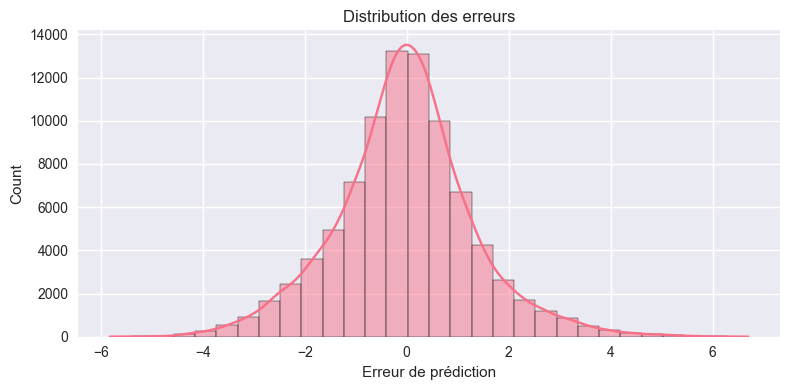

In [4]:
res = y_test - y_pred_stull_test

plt.figure(figsize=(8, 4))
sns.histplot(res, bins=30, kde=True)
plt.title("Distribution des erreurs")
plt.xlabel("Erreur de prédiction")
plt.grid(True)
plt.tight_layout()
plt.show()


Biais semble faible, bien centrée autour de 0, distribution symétrique, courbe lisse, 

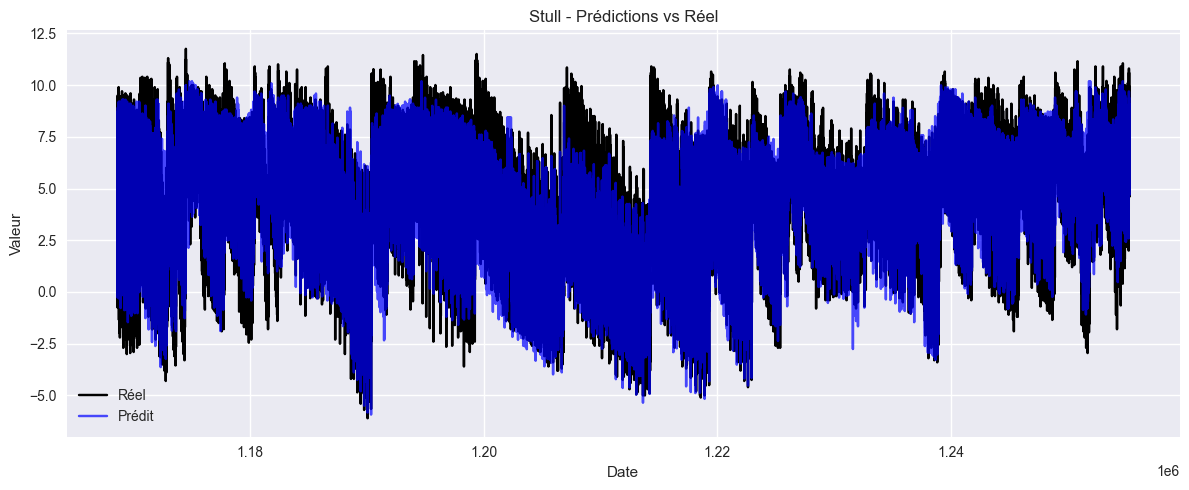

In [5]:
def plot_time_series(y_true, y_pred, title="Évolution temporelle"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true.index, y_true, label="Réel", color="black")
    plt.plot(y_true.index, y_pred, label="Prédit", color="blue", alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_time_series(y_test, y_pred_stull_test, title="Stull - Prédictions vs Réel")


### MÉTHODE 2 : RÉGRESSION POLYNOMIALE

In [6]:
print("\n" + "="*50)
print("MÉTHODE 2 : RÉGRESSION POLYNOMIALE")
print("="*50)

# Transformation polynomiale
poly = PolynomialFeatures(degree=1, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Modèle Ridge
ridge_model = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
ridge_model.fit(X_train_poly, y_train)

y_pred_poly_train = ridge_model.predict(X_train_poly)
y_pred_poly_test = ridge_model.predict(X_test_poly)
Resultat["Poly"] = y_pred_poly_test

# Métriques Polynomiale
mse_poly_train = mean_squared_error(y_train, y_pred_poly_train)
r2_poly_train = r2_score(y_train, y_pred_poly_train)

mse_poly_test = mean_squared_error(y_test, y_pred_poly_test)
r2_poly_test = r2_score(y_test, y_pred_poly_test)

print(f"Alpha: {ridge_model.alpha_}")
print(f"Train - MSE: {mse_poly_train:.3f}, R²: {r2_poly_train:.3f}")
print(f"Test - MSE: {mse_poly_test:.3f}, R²: {r2_poly_test:.3f}")


MÉTHODE 2 : RÉGRESSION POLYNOMIALE
Alpha: 100.0
Train - MSE: 1.293, R²: 0.903
Test - MSE: 1.343, R²: 0.825


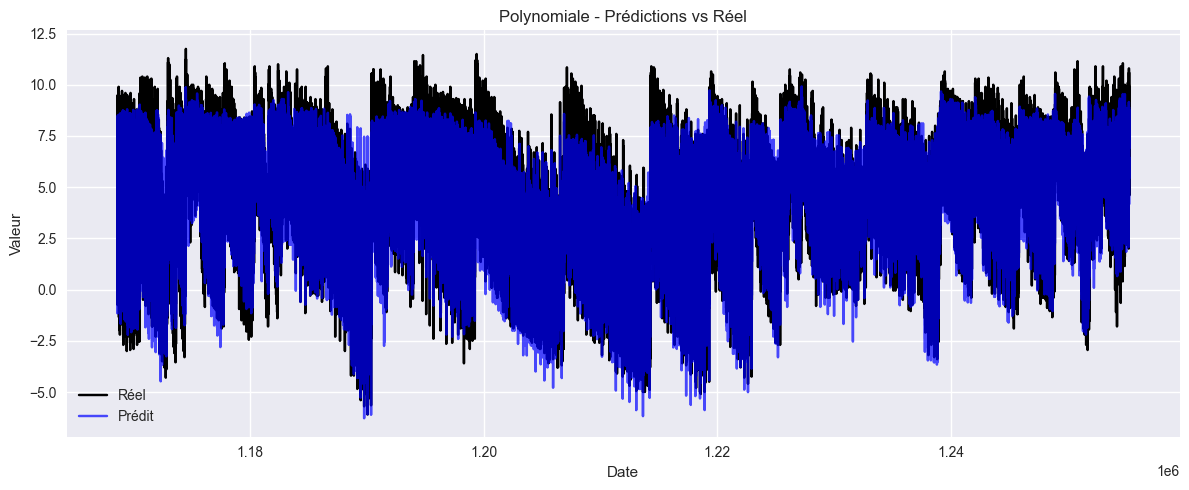

In [7]:
plot_time_series(y_test, y_pred_poly_test, title="Polynomiale - Prédictions vs Réel")


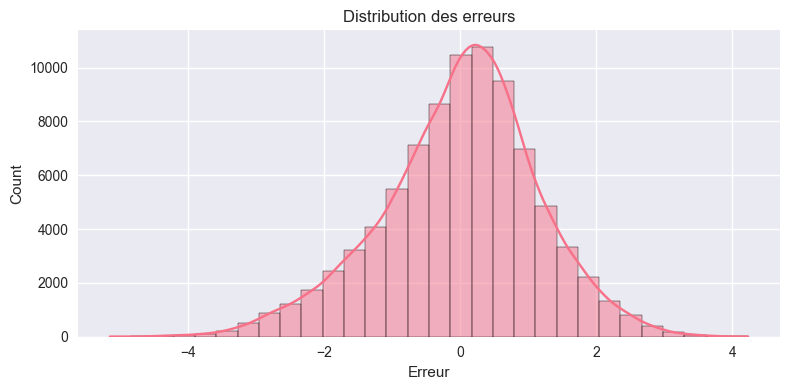

In [8]:
res = y_test - y_pred_poly_test

plt.figure(figsize=(8, 4))
sns.histplot(res, bins=30, kde=True)
plt.title("Distribution des erreurs")
plt.xlabel("Erreur")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
feature_names = poly.get_feature_names_out(input_features=Colonnes_Utilisées)

coefficients = ridge_model.coef_

intercept = ridge_model.intercept_

coef_df = pd.DataFrame({
    "Var": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

coef_df

,Var,Coefficient
6,VPD,-2.662775
0,T2M,1.031743
9,PRECIP,0.099205
4,WS10M,0.053430
1,DEWT2M,-0.039867
8,SSI,0.013132
3,WS2M,0.012216
2,RH2M,0.010348
7,CLDC,0.003606
5,WD,0.000337


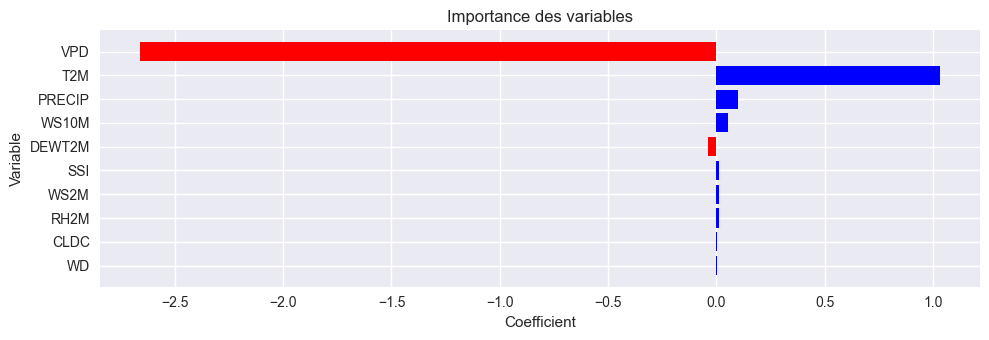

In [10]:
colors = coef_df["Coefficient"].apply(lambda x: "blue" if x > 0 else "red")

plt.figure(figsize=(10, len(coef_df) * 0.35))
bars = plt.barh(coef_df["Var"], coef_df["Coefficient"], color=colors)
plt.gca().invert_yaxis()

plt.title("Importance des variables")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


### MÉTHODE 3 : RANDOM FOREST

In [11]:
    print("\n" + "="*50)
    print("MÉTHODE 3 : RANDOM FOREST")
    print("="*50)

    # Modèle Random Forest avec paramètres par défaut
    rf_model = RandomForestRegressor(n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_pred_rf_train = rf_model.predict(X_train)
    y_pred_rf_test = rf_model.predict(X_test)
    Resultat["RF"] = y_pred_rf_test

    # Métriques Random Forest
    mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
    r2_rf_train = r2_score(y_train, y_pred_rf_train)

    mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
    r2_rf_test = r2_score(y_test, y_pred_rf_test)

    print(f"Train - MSE: {mse_rf_train:.3f}, R²: {r2_rf_train:.3f}")
    print(f"Test - MSE: {mse_rf_test:.3f}, R²: {r2_rf_test:.3f}")


MÉTHODE 3 : RANDOM FOREST
Train - MSE: 0.191, R²: 0.986
Test - MSE: 1.508, R²: 0.803


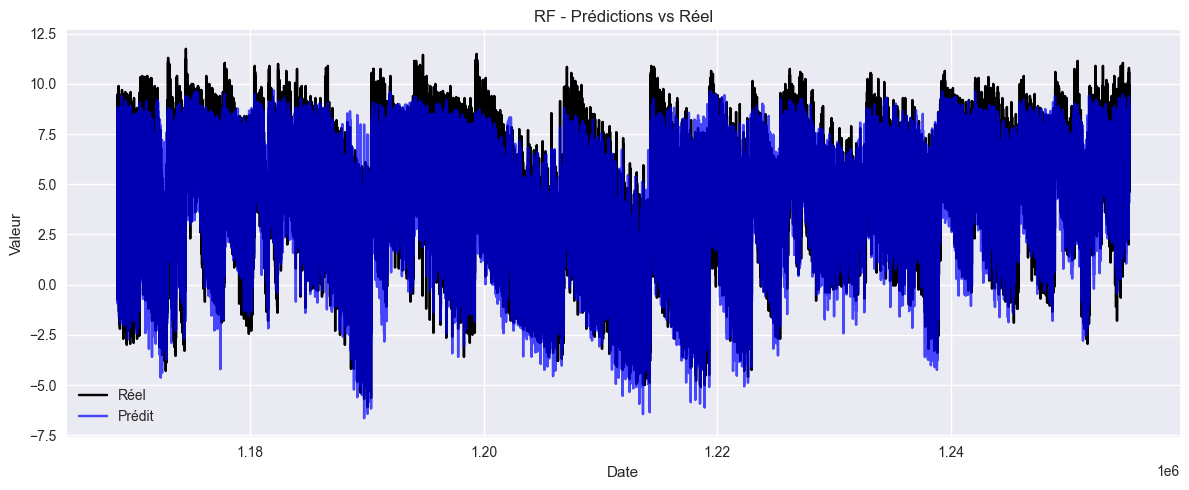

In [12]:
plot_time_series(y_test, y_pred_rf_test, title="RF - Prédictions vs Réel")

## TABLEAU COMPARATIF

In [13]:
print("\n" + "="*50)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("="*50)

# Création du DataFrame de comparaison
comparison_data = {
    'Méthode': ['Stull', 'Poly', 'Random Forest'],
    'MSE_Train': [mse_stull_train, mse_poly_train, mse_rf_train],
    'R²_Train': [r2_stull_train, r2_poly_train, r2_rf_train],
    'MSE_Test': [mse_stull_test, mse_poly_test, mse_rf_test],
    'R²_Test': [r2_stull_test, r2_poly_test, r2_rf_test]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.round(3)


TABLEAU COMPARATIF DES PERFORMANCES


,Méthode,MSE_Train,R²_Train,MSE_Test,R²_Test
0,Stull,1.894,0.858,1.835,0.760
1,Poly,1.293,0.903,1.343,0.825
2,Random Forest,0.191,0.986,1.508,0.803


Je suppose dans un premier temps au vu de ces résultats que : Ridge > RF > Stull.. 
Overfitting pour RF ?

### CORRECTION DE l'OVERFITTING

In [14]:
# Calcul de l'overfitting
print("\n" + "="*50)
print("Différence Train-Test")
print("="*50)

overfitting_data = {
    'Méthode': ['Stull', 'Poly', 'Random Forest'],
    'Diff_R²': [r2_stull_train - r2_stull_test, 
                r2_poly_train - r2_poly_test, 
                r2_rf_train - r2_rf_test],
    'Diff_MSE': [mse_stull_test - mse_stull_train,
                 mse_poly_test - mse_poly_train,
                 mse_rf_test - mse_rf_train]
}

overfitting_df = pd.DataFrame(overfitting_data)
overfitting_df.round(3)


Différence Train-Test


,Méthode,Diff_R²,Diff_MSE
0,Stull,0.098,-0.059
1,Poly,0.078,0.050
2,Random Forest,0.183,1.316


In [15]:
# Modèle Random Forest avec paramètres
rf_model = RandomForestRegressor(n_estimators=12, max_depth=9, max_features=14, min_samples_split=7, min_samples_leaf=116, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)
Resultat["RF"] = y_pred_rf_test

# Métriques Random Forest
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print(f"Train - MSE: {mse_rf_train:.3f}, R²: {r2_rf_train:.3f}")
print(f"Test - MSE: {mse_rf_test:.3f}, R²: {r2_rf_test:.3f}")

Train - MSE: 1.265, R²: 0.905
Test - MSE: 1.354, R²: 0.823


### VISUALISATIONS


VISUALISATION


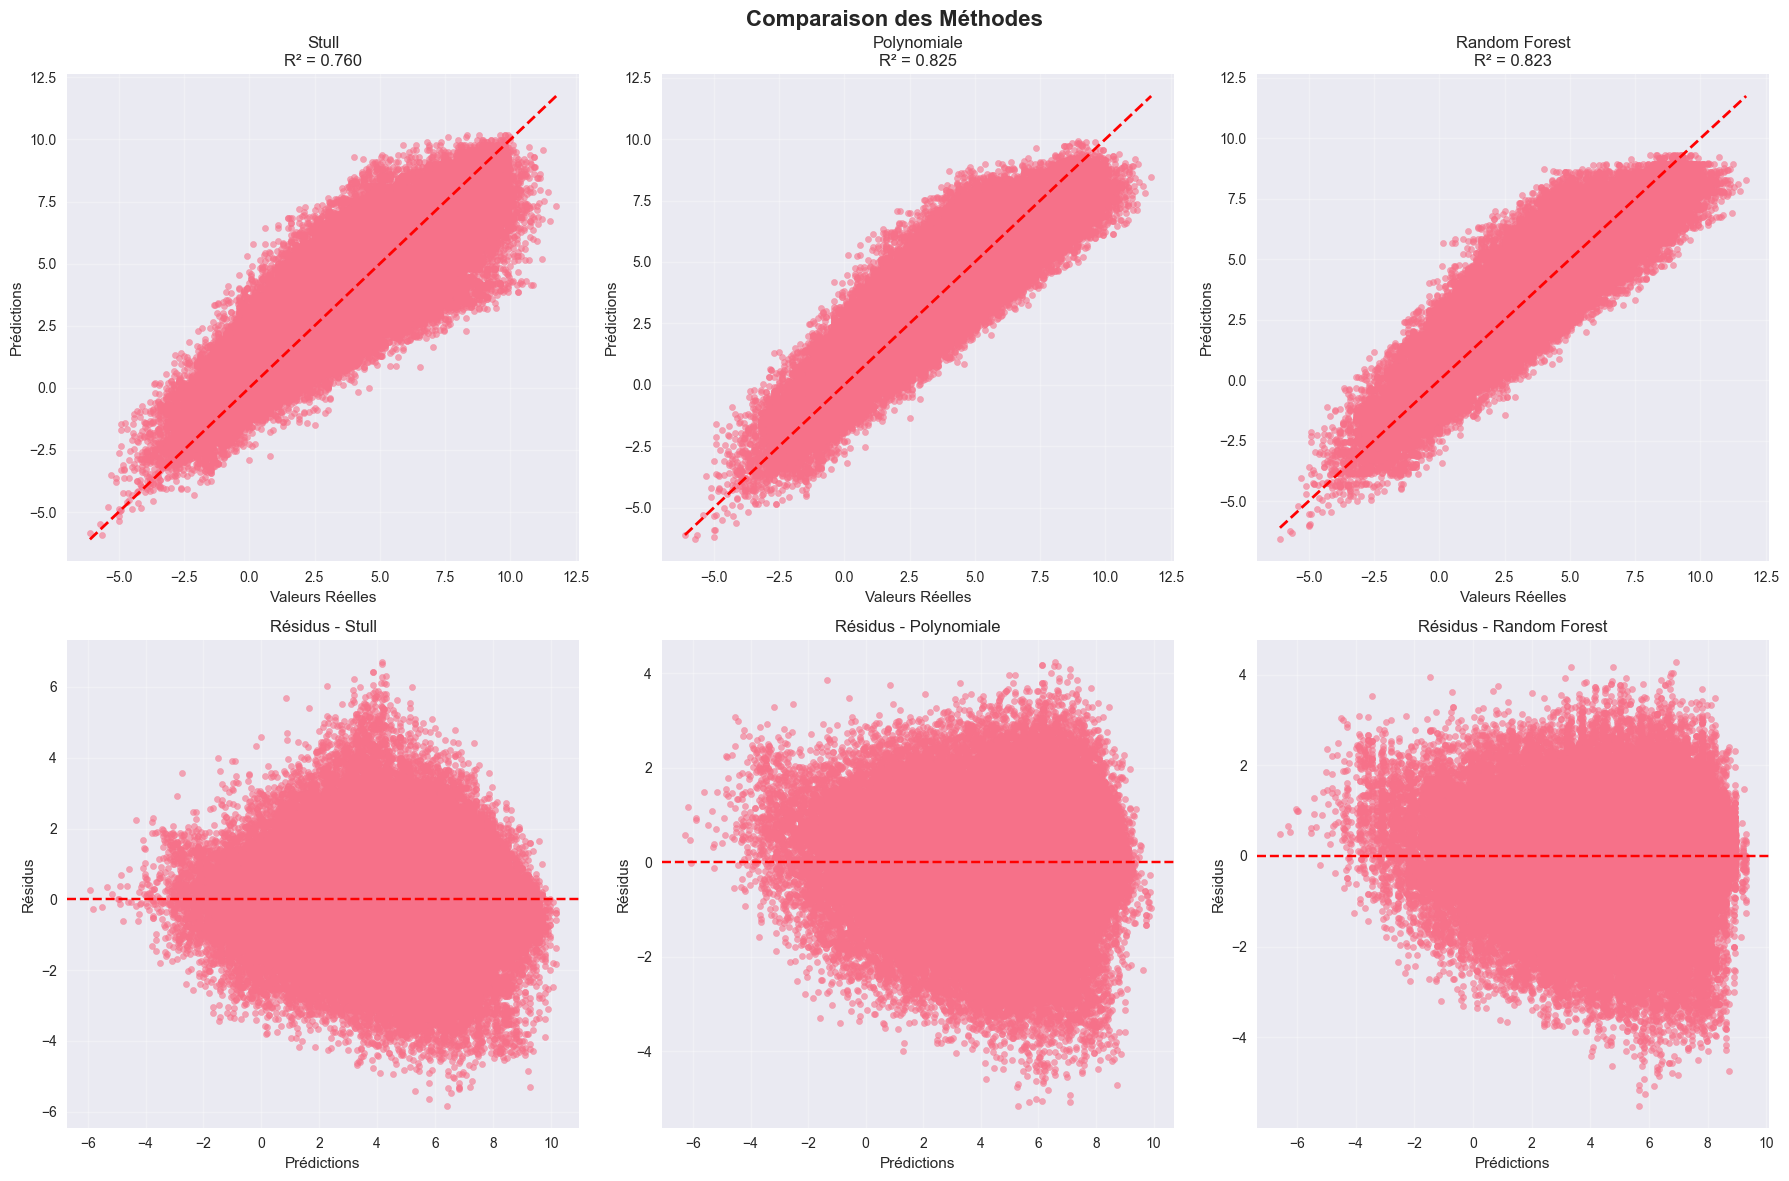

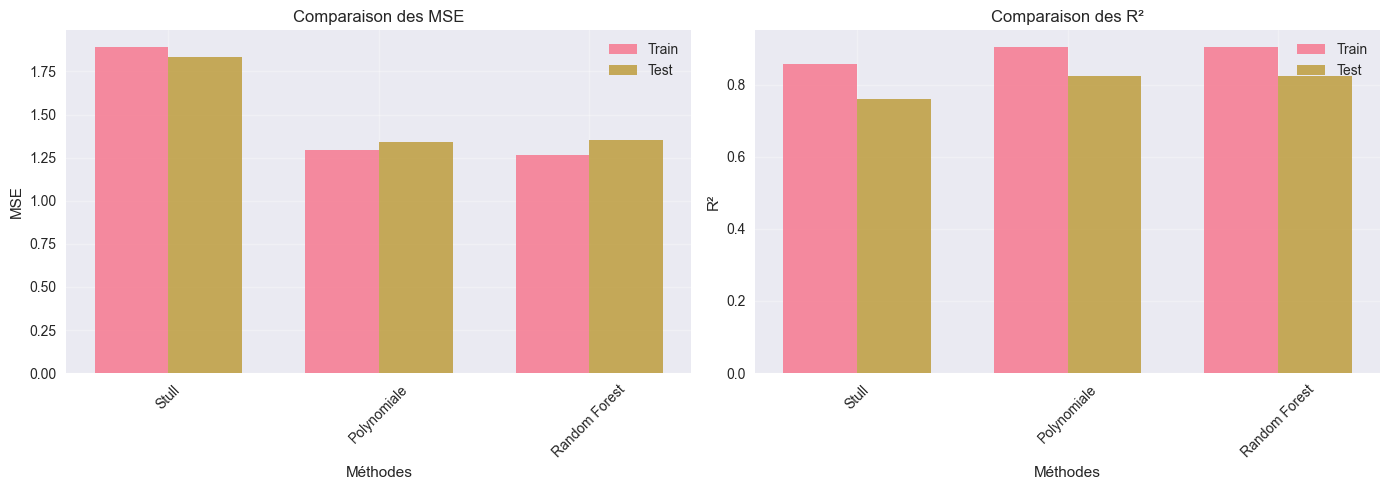

In [16]:
print("\n" + "="*50)
print("VISUALISATION")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparaison des Méthodes', fontsize=16, fontweight='bold')

methods = ['Stull', 'Polynomiale', 'Random Forest']
predictions_test = [y_pred_stull_test, y_pred_poly_test, y_pred_rf_test]
r2_scores_test = [r2_stull_test, r2_poly_test, r2_rf_test]

for i, (method, pred, r2) in enumerate(zip(methods, predictions_test, r2_scores_test)):
    # Scatter plot
    axes[0, i].scatter(y_test, pred, alpha=0.6, s=20)
    axes[0, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, i].set_xlabel('Valeurs Réelles')
    axes[0, i].set_ylabel('Prédictions')
    axes[0, i].set_title(f'{method}\nR² = {r2:.3f}')
    axes[0, i].grid(True, alpha=0.3)
    
    # Résidus
    residuals = y_test - pred
    axes[1, i].scatter(pred, residuals, alpha=0.6, s=20)
    axes[1, i].axhline(y=0, color='r', linestyle='--')
    axes[1, i].set_xlabel('Prédictions')
    axes[1, i].set_ylabel('Résidus')
    axes[1, i].set_title(f'Résidus - {method}')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graphique de comparaison des différents métriques
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['MSE', 'R²']
train_values = [[mse_stull_train, mse_poly_train, mse_rf_train],
                [r2_stull_train, r2_poly_train, r2_rf_train]]
test_values = [[mse_stull_test, mse_poly_test, mse_rf_test],
               [r2_stull_test, r2_poly_test, r2_rf_test]]

x = np.arange(len(methods))
width = 0.35

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(x - width/2, train_values[i], width, label='Train', alpha=0.8)
    ax.bar(x + width/2, test_values[i], width, label='Test', alpha=0.8)
    ax.set_xlabel('Méthodes')
    ax.set_ylabel(metric)
    ax.set_title(f'Comparaison des {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ANALYSE STATISTIQUE DES RÉSIDUS

In [17]:
print("\n" + "="*50)
print("ANALYSE STATISTIQUE DES RÉSIDUS")
print("="*50)

residuals_data = {
    'Stull': y_test - y_pred_stull_test,
    'Polynomiale': y_test - y_pred_poly_test,
    'Random Forest': y_test - y_pred_rf_test
}

for method, residuals in residuals_data.items():
    print(f"\n{method}:")
    print(f"  Moyenne des résidus: {residuals.mean():.3f}")
    print(f"  Écart-type des résidus: {residuals.std():.3f}")
    print(f"  Test de normalité (Shapiro): p-value = {stats.shapiro(residuals)[1]:.3f}")


ANALYSE STATISTIQUE DES RÉSIDUS

Stull:
  Moyenne des résidus: -0.042
  Écart-type des résidus: 1.354
  Test de normalité (Shapiro): p-value = 0.000

Polynomiale:
  Moyenne des résidus: -0.005
  Écart-type des résidus: 1.159
  Test de normalité (Shapiro): p-value = 0.000

Random Forest:
  Moyenne des résidus: -0.001
  Écart-type des résidus: 1.163
  Test de normalité (Shapiro): p-value = 0.000


### IMPORTANCE DES VARIABLES

In [18]:
print("\n" + "="*50)
print("IMPORTANCE DES VARIABLES")
print("="*50)

feature_importance = pd.DataFrame({
    'Var': Colonnes_Utilisées,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance


IMPORTANCE DES VARIABLES


,Var,Importance
0,T2M,0.979291
1,DEWT2M,0.012861
7,CLDC,0.004729
4,WS10M,0.001071
3,WS2M,0.000933
9,PRECIP,0.000404
8,SSI,0.000401
5,WD,0.000196
2,RH2M,0.000079
6,VPD,0.000034


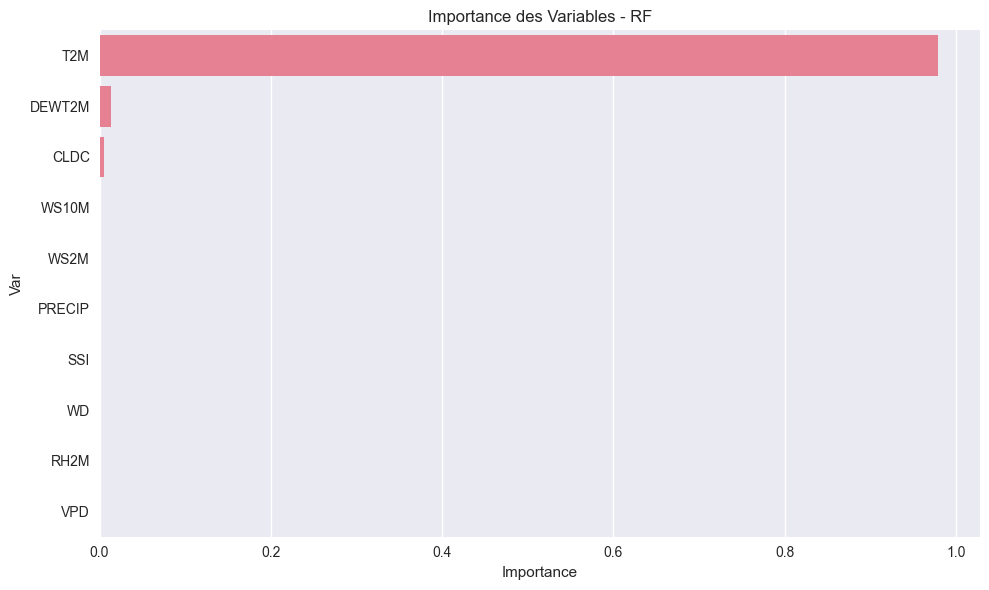

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Var')
plt.title('Importance des Variables - RF')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

T2M est celle qui joue le plus, on peut dire que notre variable est très corolé à celle ci.

In [20]:
df.corr()

,hour,station_id,nbre_records,T2M,DEWT2M,RH2M,WS2M,WS10M,WD,VPD,CLDC,SSI,PRECIP,lat,lon,T2M_D_med,T2M_U_med
hour,1.000000,-0.011403,-0.058265,0.201323,0.041322,-0.207497,0.079640,0.079638,0.030984,0.239339,-0.062426,0.006270,-0.000605,0.006471,0.017787,0.190177,0.166852
station_id,-0.011403,1.000000,0.081968,-0.027465,-0.031435,-0.017924,-0.084089,-0.084100,-0.022758,0.003933,-0.042340,0.034129,0.009483,-0.142096,-0.081395,-0.026020,-0.035689
nbre_records,-0.058265,0.081968,1.000000,-0.132459,-0.140416,-0.043250,-0.014575,-0.014570,-0.030381,0.010194,-0.073073,-0.029933,-0.054404,0.016909,0.035781,-0.144877,-0.156767
T2M,0.201323,-0.027465,-0.132459,1.000000,0.770896,-0.133399,0.191898,0.191884,0.145396,0.338022,0.226378,0.076133,0.125893,-0.047464,-0.038627,0.948845,0.941063
DEWT2M,0.041322,-0.031435,-0.140416,0.770896,1.000000,0.522767,-0.083114,-0.083127,0.075109,-0.326974,0.414815,0.075566,0.188430,0.047035,-0.150712,0.731084,0.790160
RH2M,-0.207497,-0.017924,-0.043250,-0.133399,0.522767,1.000000,-0.393368,-0.393367,-0.080850,-0.955565,0.358001,0.017411,0.131472,0.133200,-0.185559,-0.126231,-0.024254
WS2M,0.079640,-0.084089,-0.014575,0.191898,-0.083114,-0.393368,1.000000,0.999999,0.172955,0.400055,-0.014608,0.020022,0.056567,0.066938,0.128910,0.228113,0.185691
WS10M,0.079638,-0.084100,-0.014570,0.191884,-0.083127,-0.393367,0.999999,1.000000,0.172947,0.400054,-0.014610,0.020017,0.056567,0.066923,0.128941,0.228100,0.185678
WD,0.030984,-0.022758,-0.030381,0.145396,0.075109,-0.080850,0.172955,0.172947,1.000000,0.103599,0.039255,0.006331,0.036356,-0.039867,0.057385,0.153662,0.147392
VPD,0.239339,0.003933,0.010194,0.338022,-0.326974,-0.955565,0.400055,0.400054,0.103599,1.000000,-0.282732,-0.001311,-0.107359,-0.137505,0.165829,0.319779,0.219713


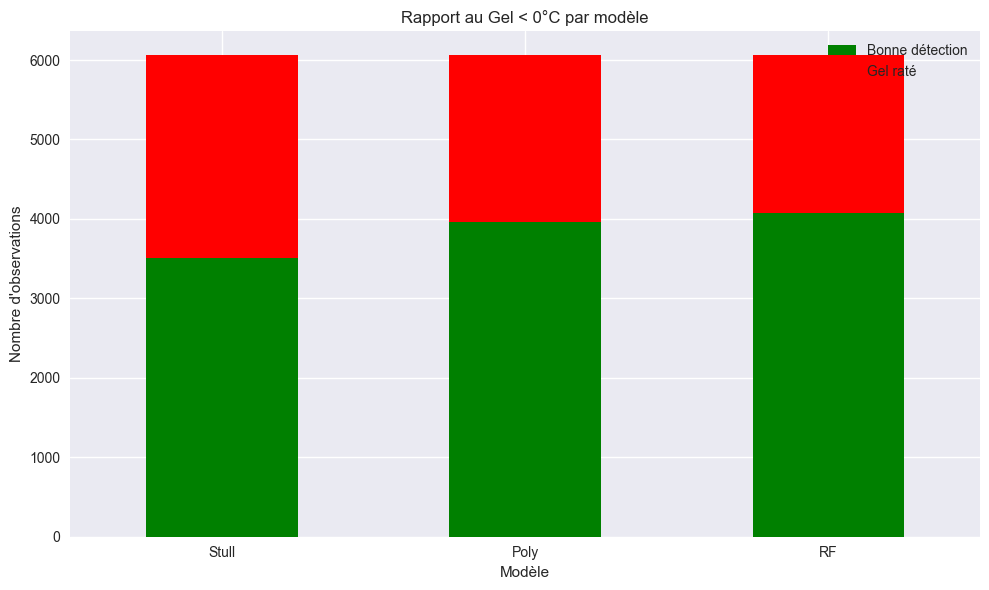

In [21]:
modeles = ["Stull", "Poly", "RF"]

def evaluer_detection(df, modeles):
    resultats = []
    for modele in modeles:
        vrai_gel = df["Réel"] < 0
        predit_gel = df[modele] < 0

        TP = (vrai_gel & predit_gel).sum()
        FN = (vrai_gel & ~predit_gel).sum()

        resultats.append({
            "Modèle": modele,
            "Bonne détection": TP,
            "Gel raté": FN
        })
    return pd.DataFrame(resultats)

df_resultats = evaluer_detection(Resultat, modeles=modeles)

# Graphique
df_resultats.set_index("Modèle")[["Bonne détection", "Gel raté"]].plot(
    kind="bar", stacked=True, color=["green", "red"], figsize=(10, 6)
)
plt.title("Rapport au Gel < 0°C par modèle")
plt.ylabel("Nombre d'observations")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [22]:
len(Resultat)

86670

In [23]:
Resultat[Resultat["Réel"]<0]

,Réel,Stull,Poly,RF
1168645,-0.35,0.983052,0.080039,0.156147
1168648,-0.50,0.686267,-0.217939,0.015023
1168659,-0.75,-0.260078,-1.163623,-1.221368
1168680,-0.35,0.548156,0.191123,-0.000004
1168729,-0.25,0.299613,-0.352968,-0.615388
...,...,...,...,...
1254241,-1.80,1.567360,0.715920,0.552224
1254245,-0.50,1.118924,0.731304,0.721042
1254543,-0.10,1.756274,1.186969,1.072238
1254552,-0.10,1.493833,0.879941,0.774071


In [24]:
Resultat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Réel,86670.0,4.540567,2.766308,-6.100000,2.800000,4.800000,6.700000,11.750000
Stull,86670.0,4.582125,2.498477,-5.923194,2.980736,4.879528,6.498073,10.186419
Poly,86670.0,4.545844,2.539342,-6.280475,2.995041,4.955334,6.492589,9.918820
RF,86670.0,4.541500,2.571021,-6.578234,3.002279,4.952435,6.520733,9.312390


## Conclusion

Parmi les modèles testés, le modèle polynomial de degré 1 s’est montré le plus adapté à nos données : il offre un bon compromis entre précision donnée par le $R^2$ et la généralisation avec le MSE, ce qui en fait un candidat robuste pour notre usage métier ici.

Le modèle Stull, bien que simplifié et sans phase d’entraînement, donne des résultats plutôt intéressants avec un excellent rapport coût/résultat. Il reste donc une solution de secours pertinente, notamment pour des contextes embarqués ou en cas de défaillance du modèle principal.

En ce qui concerne les situations critiques comme le risque de gel (T2M_U_med < 0°C), notre modèle polynomiale reste le plus fiable pour minimiser les erreurs.

## Choix Hyperparamètre

In [1]:
import script

In [4]:
script.optimise_model(model="lasso", technique="bayes", graphs=True, cv=5, xlsx=True, nbr_iter=50)

#######################################

Lancement de lasso en bayes (50 modèles) :

Modèle 1/50: 55.84s | R²: 89.99% | MSE: 0.1
Modèle 2/50: 1.284s | R²: 89.99% | MSE: 0.1
Modèle 3/50: 52.179s | R²: 89.99% | MSE: 0.1
Modèle 4/50: 2.299s | R²: 89.99% | MSE: 0.1
Modèle 5/50: 6.196s | R²: 89.99% | MSE: 0.1
Modèle 6/50: 1m17s | R²: 89.99% | MSE: 0.1
Modèle 7/50: 1.74s | R²: 89.99% | MSE: 0.1
Modèle 8/50: 9.435s | R²: 90.0% | MSE: 0.1
Modèle 9/50: 5.638s | R²: 90.0% | MSE: 0.1
Modèle 10/50: 30.528s | R²: 90.0% | MSE: 0.1
Modèle 11/50: 1m11s | R²: 90.0% | MSE: 0.1
Modèle 12/50: 8.18s | R²: 90.0% | MSE: 0.1
Modèle 13/50: 1.984s | R²: 90.0% | MSE: 0.1
Modèle 14/50: 9.809s | R²: 90.0% | MSE: 0.1
Modèle 15/50: 14.886s | R²: 90.0% | MSE: 0.1
Modèle 16/50: 40.441s | R²: 90.0% | MSE: 0.1
Modèle 17/50: 8.627s | R²: 90.0% | MSE: 0.1
Modèle 18/50: 5.641s | R²: 90.0% | MSE: 0.1
Modèle 19/50: 56.28s | R²: 90.0% | MSE: 0.1
Modèle 20/50: 58.741s | R²: 90.0% | MSE: 0.1
Modèle 21/50: 7.644s | R²: 90.0% | M

In [ ]:
# script.optimise_model(model="ridge", technique="bayes", graphs=True, cv=5, xlsx=True, frame= True, nbr_iter=100)

In [ ]:
# script.optimise_model(model="rforest", technique="bayes", graphs=True, cv=5, xlsx=True, frame= True, nbr_iter=50)

## END
Temps Approximative : 3h14